In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import matplotlib.pyplot as plt


In [22]:
# Create dataloaders for MNIST dataset
train_dataset = tv.datasets.MNIST(root='./data', train=True, transform=tv.transforms.ToTensor(), download=True)
    # Root: where we want the data to be stored/saved
    # Train: True for training data, False for testing data
    # Transform: How to transform the data, here we want it to be in tensor format
    # Download: True if we want to download the data, False if we already have it
test_dataset = tv.datasets.MNIST(root='./data', train=False, transform=tv.transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True) # Training loader
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False) # Testing loader

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

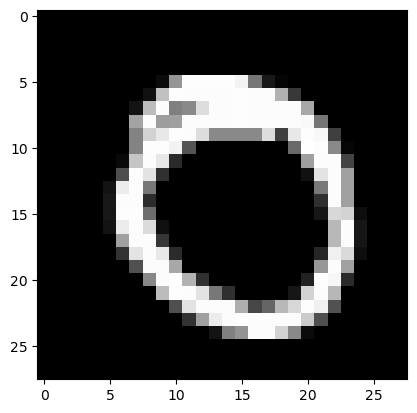

In [25]:
# Look at dimensions of data
for X,T in train_loader: # datapoints and targets
    print(X[0,0,:,:]) # First image, first channel, all rows, all columns
    print(T[0]) # First target
    plt.imshow(X[0,0,:,:].numpy(), cmap='gray') # Plot first image
    break

In [33]:
# Build the neural network model

class ConvNet(torch.nn.Module): # 'Module' is a base class for all neural network modules
    def __init__(self): # Define the layers of the network
        super().__init__() # Call the initialisation method of the neural network module
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=0) # 1 input channel (black and white), 32 output channels, 3x3 kernel, no pixel padding
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=4, padding=0) # 32 input channels, 16 output channels, 4x4 kernel, no pixel padding
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=0) # 16 input channels, 8 output channels, 3x3 kernel, no pixel padding
        # We start with a 28x28 image, with no padding, and apply 3 convolutional neural nets (dropping the image size by 2 or 3 each time)
        # The reduction in size of each dimension of the image, with each convolutional layer, is the size of the kernel - 1
        self.fc = nn.Linear(in_features=3*3*16, out_features=10) # 3*3*16 input features, 10 output features (logits for each class)


    def forward(self, x): # Define the forward pass of the network
        x = self.conv1(x) # Pass the input through the first convolutional layer
        x = F.relu(x) # Pass the output through a nonlinearity (ReLU function)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # Pass the output through a max pooling layer to downsample (reduces the size of the image by factor of 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = x.reshape(-1,16*3*3) # Reshape the output to be a 1D vector to pass into the linear layer; the -1 means that the batch size is automatically inferred
        x = self.fc(x) # Pass the output through the (fully-connected) linear layer
        return x
        

In [42]:
# Instantiate the model
model = ConvNet()

In [44]:
# Create an optimiser
optimiser = optim.Adam(model.parameters(), lr=0.001) # Adam optimiser, learning rate of 0.001

In [45]:
# Create a loss function (we're using the logit cross entropy loss)
loss_function = nn.CrossEntropyLoss()

In [46]:
# Let's go
from tqdm import tqdm # tqdm is a progress bar library
losses = [] # Create a list to store the losses

for X, T in train_loader: # Loop over the training data
  optimiser.zero_grad() # Zero out the gradients so we don't accumulate them
  logits = model(X) # Pass the input through the model to get the logits
  loss = loss_function(logits, T) # Calculate the loss
  loss.backward() # Backpropagate the loss
  optimiser.step() # Update the weights
  losses.append(loss.item()) # Append the loss to the list of losses


Text(0, 0.5, 'Loss')

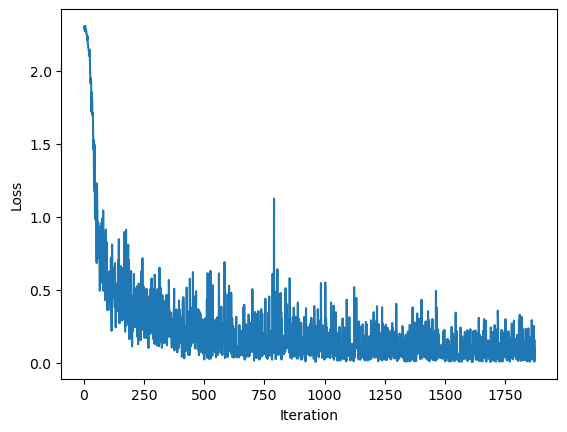

In [47]:
# Print the loss 
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [48]:
def test_accuracy(model,test_loader):
    correct = 0
    total = 0

    for X,T in test_loader:
        logits = model(X) # Pass the input through the model to get the logits
        predicted = torch.argmax(logits, dim=1) # Get the predicted class
        correct += (predicted == T).sum()
        total += len(T)
    return correct/total

In [49]:
print(test_accuracy(model, test_loader)) # Print the accuracy on the test set

tensor(0.9727)
